# LLM Finetuning Hyperparameter Optimisation

## 0. Setup

In [14]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import json

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. LLaMA Parameter Optimisation

### 1.1. Training

*Question 1: Which model does the training save? Which performance is it based off of?*

`load_best_model_at_end=True,` combined with `eval_strategy="epoch", save_strategy="epoch", save_total_limit=1,` means that 

- The model is evaluated at the end of each epoch.
- Only the best model according to the default metric is retained at the end (save_total_limit=1 prevents clutter).
- `Trainer` will automatically reload the best-performing checkpoint at the end based on the evaluation loss (by default).

So **the model saved is the one with the lowest validation loss at the end of its epoch**.


*Question 2: Which training/LoRA parameters can be explored to improve performance?*

There are two optimisation targets:
- LoRA configuration
- Training hyperparameters

(A) LoRA parameters (from LoraConfig) include
- r (e.g. 4 ro 32)
- lora_alpha (e.g. 8 to 64)
- target modules (e.g q_proj, k_proj, v_proj, o_proj, but also gate_proj, down_proj, up_proj)
- lora_dropout (0, or 0.05, 0.1 if overfitting)

(B) Training hyperparameters (from TrainingArguments)
- learning_rate (e.g. 9e-5 to 2e-4)
- per_device_train_batch_size (e.g. 4 to 16)
- num_train_epochs
- warmup_ratio
- lr_scheduler_type
- weight_decay
- gradient_accumulation_steps

In [2]:
import re
import pandas as pd
from pathlib import Path

# Paths
log_path = "../results/random_searches/llama_search_runs/search_progress_log.txt"
output_dir = Path("../results/latex_tables")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "top10_llama_search.tex"

# Read log
with open(log_path, "r") as f:
    log_lines = f.readlines()

entries = []
for line in log_lines:
    run_match = re.search(r"run_\d+_r(\d+)_alpha(\d+)_drop([0-9.]+)_lr([\deE.-]+)_bs(\d+)", line)
    f1_match = re.search(r"macro_f1: ([0-9.]+)", line)
    if run_match and f1_match:
        r, alpha, drop, lr, bs = run_match.groups()
        entries.append({
            "LoRA rank ($r$)": int(r),
            "LoRA alpha": int(alpha),
            "LoRA dropout": float(drop),
            "Learning rate": lr,
            "Batch size": int(bs),
            "Macro-F1": float(f1_match.group(1))
        })

# DataFrame and top 10
df = pd.DataFrame(entries)
top10 = df.sort_values("Macro-F1", ascending=False).head(10).reset_index(drop=True)

# Round values
top10["LoRA dropout"] = top10["LoRA dropout"].round(2)
top10["Macro-F1"] = top10["Macro-F1"].round(2)

# Convert all values to string for LaTeX formatting
top10 = top10.astype(str)

# Bold only the best Macro-F1 value
best_idx = top10["Macro-F1"].astype(float).idxmax()
top10.at[best_idx, "Macro-F1"] = f"\\textbf{{{top10.at[best_idx, 'Macro-F1']}}}"

# Reorder columns and add vertical bar before Macro-F1
columns = ["LoRA rank ($r$)", "LoRA alpha", "LoRA dropout", "Learning rate", "Batch size", "Macro-F1"]
column_format = "lllll|l"  # vertical bar before last column

# Generate LaTeX
latex_table = top10.to_latex(index=False, escape=False, column_format=column_format)

# Wrap in resizebox with caption and label
wrapped_latex = f"""
\\centering
\\resizebox{{\\linewidth}}{{!}}{{%
{latex_table}
}}
"""

# Save LaTeX file
with open(output_file, "w") as f:
    f.write(wrapped_latex)

print(f"✅ LaTeX table with top 10 and bolded best Macro-F1 saved to {output_file}")

✅ LaTeX table with top 10 and bolded best Macro-F1 saved to ../results/latex_tables/top10_llama_search.tex


## 2. RoBERTa Parameter Optimisation

### 2.1. Training

This section describes how I fine-tuned a RoBERTa model to classify sentences as containing Social Determinants of Health (SDoH) or not.

#### Loss Function

I use **Binary Cross-Entropy with Logits Loss** (`BCEWithLogitsLoss`) with a `pos_weight` parameter to address class imbalance:

\[
\mathcal{L}(z, y) = -w \cdot \left[y \cdot \log(\sigma(z)) + (1 - y) \cdot \log(1 - \sigma(z))\right]
\]

- \( z \): raw model output (logit)
- \( y \in \{0, 1\} \): binary label
- \( \sigma(z) \): sigmoid function
- \( w = \text{pos\_weight} \): balancing weight, set to `#neg / #pos` in training data

This setup ensures greater penalty for misclassifying positive (minority class) examples.

#### Tunable Parameters

I explored the impact of the following hyperparameters on model performance:

| Category         | Parameter                  | Description                                              | Typical Values       |
|------------------|----------------------------|----------------------------------------------------------|----------------------|
| **Model**        | `num_frozen_layers`        | Number of RoBERTa encoder layers to freeze               | `0`, `6`, `10`       |
| **Training**     | `learning_rate`            | Optimizer learning rate                                  | `1e-5` to `5e-5`     |
|                  | `num_of_epochs`            | Number of training epochs                                | `3` to `10`          |
|                  | `per_device_train_batch_size` | Batch size per GPU                                      | `4`, `8`, `16`       |
| **Tokenizer**    | `max_length`               | Maximum sequence length after tokenization               | `64`, `128`          |
| **Model head**   | Dropout rate               | Dropout before classification layer                      | `0.1`, `0.3`, `0.5`  |

#### Optimization Strategy

I conduct manual grid search and record performance (macro F1, validation loss) for each combination. Best models are selected based on lowest validation loss.

In [28]:
import re
import pandas as pd
from pathlib import Path

# Paths
log_path = "../results/random_searches/roberta_search_runs/eval_loss_1.txt"
output_dir = Path("../results/latex_tables")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "top10_roberta_search.tex"

# Read log lines
entries = []
with open(log_path, "r") as f:
    for line in f:
        line = line.strip()
        match = re.search(r"lr([\deE.-]+)_bs(\d+)_drop([\d.]+)_frozen(\d+)_.*eval_loss=([\d.]+)", line)
        if match:
            lr, bs, drop, frozen, loss = match.groups()
            entries.append({
                "Learning rate": lr,
                "Batch size": int(bs),
                "Dropout": float(drop),
                "Frozen layers": int(frozen),
                "Eval loss": float(loss)
            })

# Convert to DataFrame and remove duplicates
df = pd.DataFrame(entries)
if df.empty:
    raise ValueError("❌ No entries matched — check input log format.")
df = df.drop_duplicates(subset=["Learning rate", "Batch size", "Dropout", "Frozen layers"])

# Format table
top10 = df.sort_values("Eval loss").head(10).reset_index(drop=True)
top10["Dropout"] = top10["Dropout"].round(2)
top10["Eval loss"] = top10["Eval loss"].round(3)
top10 = top10.astype(str)

# Bold the best eval loss
best_idx = top10["Eval loss"].astype(float).idxmin()
top10.loc[best_idx, "Eval loss"] = f"\\textbf{{{top10.loc[best_idx, 'Eval loss']}}}"

# Create LaTeX with vertical bar
latex_table = top10.to_latex(index=False, escape=False, column_format="llll|l")

# Wrap
wrapped_latex = f"""
\\centering
{latex_table}
"""

# Save
with open(output_file, "w") as f:
    f.write(wrapped_latex)

print(f"✅ LaTeX saved to {output_file}")

✅ LaTeX saved to ../results/latex_tables/top10_roberta_search.tex


### 2.2 Impact of parameters on performance

### 2.3 Threshold sweep for high recall

Done on the validation set.

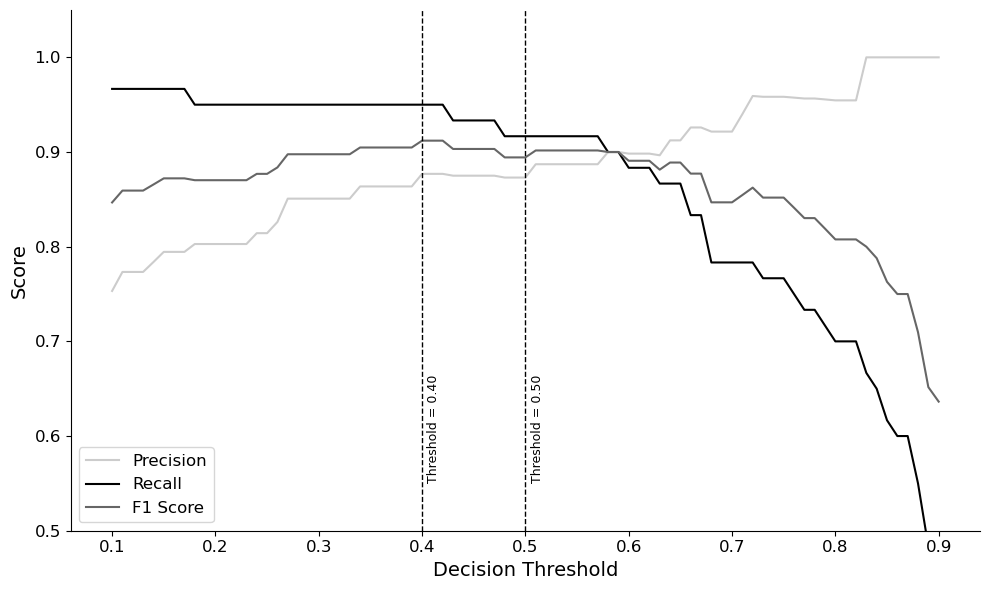

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from pathlib import Path

from src.visualisations_helpers import set_visualization_style

# Apply style
set_visualization_style()

# Load predictions
model_dir = "../results/model_training/roberta_binary/best_model/roberta-base_bs4_lr7e-05_20250726_140551/checkpoint-66"
df = pd.read_csv(f"{model_dir}/binary_predictions_val_set.csv")

# Convert labels to binary
y_true = (df["True Label"] == "Any SDoH").astype(int).values
probs = df["Prob_SDoH"].values

# Thresholds
thresholds = np.linspace(0.1, 0.9, 81)
results = []

for t in thresholds:
    y_pred = (probs > t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    results.append({"threshold": t, "precision": precision, "recall": recall, "f1": f1})

results_df = pd.DataFrame(results)

# Plot
fig, ax = plt.subplots()
ax.plot(results_df["threshold"], results_df["precision"], label="Precision", color="#cccccc")
ax.plot(results_df["threshold"], results_df["recall"], label="Recall", color="black")
ax.plot(results_df["threshold"], results_df["f1"], label="F1 Score", color="#666666")
ax.axvline(0.40, color="black", linestyle="--", linewidth=1)
ax.text(0.405, 0.55, 'Threshold = 0.40', rotation=90, va='bottom', fontsize=9, color='black')
ax.axvline(0.50, color="black", linestyle="--", linewidth=1)
ax.text(0.505, 0.55, 'Threshold = 0.50', rotation=90, va='bottom', fontsize=9, color='black')

ax.set_xlabel("Decision Threshold")
ax.set_ylabel("Score")
ax.set_ylim(0.5, 1.05)
ax.legend()
fig.tight_layout()

# Save
output_dir = Path("../results/figures/appendix")
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / "roberta_threshold_sweep_greyscale.png", dpi=300)
plt.show()
plt.close()

In [25]:
# Print metrics at selected thresholds
for thresh in [0.40, 0.50]:
    row = results_df[np.isclose(results_df["threshold"], thresh, atol=1e-4)].iloc[0]
    print(f"📊 Threshold = {thresh:.2f}")
    print(f"  Precision: {row['precision']:.3f}")
    print(f"  Recall:    {row['recall']:.3f}")
    print(f"  F1 Score:  {row['f1']:.3f}")

📊 Threshold = 0.40
  Precision: 0.877
  Recall:    0.950
  F1 Score:  0.912
📊 Threshold = 0.50
  Precision: 0.873
  Recall:    0.917
  F1 Score:  0.894


## Final Parameters

Binary classification:
- RoBERTa (125M): 
    - Lr: 7e-05
    - Batch size: 4
    - Dropout: 0.3
    - Other: {Frozen layers: 8; Threshold: 0.4}

Multilabel classification: 
- LLaMA 3.1 8B - Instruct (8B) (fine-tuned):
    - Lr: 3e-05
    - Batch size: 4
    - Dropout: 0.0
    - Other: {LoRA rank: 8; LoRA alpha: 64}

- LLaMA 3.1 8B - Instruct (8B) (few-shot):
    - Lr: -
    - Batch size: -
    - Dropout: -
    - Other: {-}
